In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sl_utils import polygon_to_rbox, rbox_to_polygon
from ssd_viz import plot_box

Using TensorFlow backend.


### computational geometry 'by hands'

https://stackoverflow.com/questions/44797713/calculate-the-area-of-intersection-of-two-rotated-rectangles-in-python

In [2]:
from math import pi, cos, sin


class Vector:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __add__(self, v):
        if not isinstance(v, Vector):
            return NotImplemented
        return Vector(self.x + v.x, self.y + v.y)

    def __sub__(self, v):
        if not isinstance(v, Vector):
            return NotImplemented
        return Vector(self.x - v.x, self.y - v.y)

    def cross(self, v):
        if not isinstance(v, Vector):
            return NotImplemented
        return self.x*v.y - self.y*v.x


class Line:
    # ax + by + c = 0
    def __init__(self, v1, v2):
        self.a = v2.y - v1.y
        self.b = v1.x - v2.x
        self.c = v2.cross(v1)

    def __call__(self, p):
        return self.a*p.x + self.b*p.y + self.c

    def intersection(self, other):
        # See e.g.     https://en.wikipedia.org/wiki/Line%E2%80%93line_intersection#Using_homogeneous_coordinates
        if not isinstance(other, Line):
            return NotImplemented
        w = self.a*other.b - self.b*other.a
        return Vector(
            (self.b*other.c - self.c*other.b)/w,
            (self.c*other.a - self.a*other.c)/w
        )


def rectangle_vertices(cx, cy, w, h, r):
    angle = pi*r/180
    dx = w/2
    dy = h/2
    dxcos = dx*cos(angle)
    dxsin = dx*sin(angle)
    dycos = dy*cos(angle)
    dysin = dy*sin(angle)
    return (
        Vector(cx, cy) + Vector(-dxcos - -dysin, -dxsin + -dycos),
        Vector(cx, cy) + Vector( dxcos - -dysin,  dxsin + -dycos),
        Vector(cx, cy) + Vector( dxcos -  dysin,  dxsin +  dycos),
        Vector(cx, cy) + Vector(-dxcos -  dysin, -dxsin +  dycos)
    )

def intersection_area(r1, r2):
    # r1 and r2 are in (center, width, height, rotation) representation
    # First convert these into a sequence of vertices

    rect1 = rectangle_vertices(*r1)
    rect2 = rectangle_vertices(*r2)

    # Use the vertices of the first rectangle as
    # starting vertices of the intersection polygon.
    intersection = rect1

    # Loop over the edges of the second rectangle
    for p, q in zip(rect2, rect2[1:] + rect2[:1]):
        if len(intersection) <= 2:
            break # No intersection

        line = Line(p, q)

        # Any point p with line(p) <= 0 is on the "inside" (or on the boundary),
        # any point p with line(p) > 0 is on the "outside".

        # Loop over the edges of the intersection polygon,
        # and determine which part is inside and which is outside.
        new_intersection = []
        line_values = [line(t) for t in intersection]
        for s, t, s_value, t_value in zip(
            intersection, intersection[1:] + intersection[:1],
            line_values, line_values[1:] + line_values[:1]):
            if s_value <= 0:
                new_intersection.append(s)
            if s_value * t_value < 0:
                # Points are on opposite sides.
                # Add the intersection of the lines to new_intersection.
                intersection_point = line.intersection(Line(s, t))
                new_intersection.append(intersection_point)

        intersection = new_intersection

    # Calculate area
    if len(intersection) <= 2:
        return 0

    return 0.5 * sum(p.x*q.y - p.y*q.x for p, q in
                     zip(intersection, intersection[1:] + intersection[:1]))



r1 = (10, 15, 15, 10, 30)
r2 = (15, 15, 20, 10, 0)
print(intersection_area(r1, r2))

#110.17763185469022

110.17763185469022


[ 10.          15.          15.          10.           0.52359879]
[ 15.  15.  20.  10.   0.]


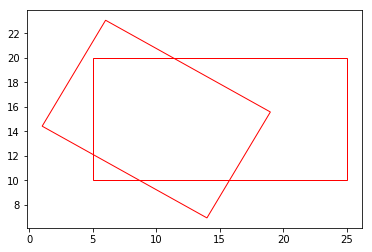

In [3]:
plt.figure()
rb1 = np.array(r1, dtype=np.float32)
rb1[-1] *= np.pi/180 # *(-1) rbox_to_polygon
print(rb1)
p1 = rbox_to_polygon(rb1)
plot_box(p1, 'polygon')
rb2 = np.array(r2, dtype=np.float32)
print(rb2)
p2 = rbox_to_polygon(rb2)
plot_box(p2, 'polygon')
ax = plt.gca()
ax.autoscale(enable=True, axis='both', tight=None)
plt.show()

### shapely

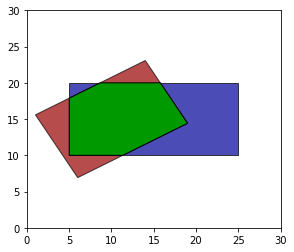

In [4]:
import shapely
import shapely.geometry
from descartes import PolygonPatch

class RotatedRect:
    def __init__(self, cx, cy, w, h, angle):
        self.cx = cx
        self.cy = cy
        self.w = w
        self.h = h
        self.angle = angle

    def get_contour(self):
        w = self.w
        h = self.h
        c = shapely.geometry.box(-w/2.0, -h/2.0, w/2.0, h/2.0)
        rc = shapely.affinity.rotate(c, self.angle)
        return shapely.affinity.translate(rc, self.cx, self.cy)

    def intersection(self, other):
        return self.get_contour().intersection(other.get_contour())


r1 = RotatedRect(10, 15, 15, 10, 30)
r2 = RotatedRect(15, 15, 20, 10, 0)

fig = plt.figure(1, figsize=(10, 4))
ax = fig.add_subplot(121)
ax.set_xlim(0, 30)
ax.set_ylim(0, 30)

ax.add_patch(PolygonPatch(r1.get_contour(), fc='#990000', alpha=0.7))
ax.add_patch(PolygonPatch(r2.get_contour(), fc='#000099', alpha=0.7))
ax.add_patch(PolygonPatch(r1.intersection(r2), fc='#009900', alpha=1))

plt.show()

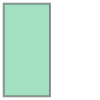

In [5]:
w = 10
h = 20
shapely.geometry.box(-w/2.0, -h/2.0, w/2.0, h/2.0)

In [6]:
rbox1 = np.array([10, 15, 15, 10, 30])
#rbox1[-1] *= np.pi/180
rbox2 = np.array([15, 15, 20, 10, 0])

def iou_polygon(rbox1, rbox2):
    cx, cy, w, h, angle = rbox1
    c = shapely.geometry.box(-w/2.0, -h/2.0, w/2.0, h/2.0)
    rc = shapely.affinity.rotate(c, angle)
    b1 = shapely.affinity.translate(rc, cx, cy)
    
    cx, cy, w, h, angle = rbox2
    c = shapely.geometry.box(-w/2.0, -h/2.0, w/2.0, h/2.0)
    rc = shapely.affinity.rotate(c, angle)
    b2 = shapely.affinity.translate(rc, cx, cy)
    
    I = b1.intersection(b2)
    
    if not I.is_empty:
        Ia = I.area
        Ua = b1.area + b2.area - Ia
        IoU = Ia / Ua
        return IoU
    else:
        return 0.0
    
print(iou_polygon(rbox1, rbox2))

b2 = np.tile(rbox2, (10,1))
b2[:,1] += np.arange(10)

np.array([iou_polygon(rbox1, b) for b in b2])

0.4594134930230231


array([ 0.45941349,  0.45186292,  0.42069517,  0.36885369,  0.30556628,
        0.24189104,  0.18563748,  0.1363855 ,  0.09306736,  0.05811405])

In [7]:
%%timeit
for i in range(100):
    iou_polygon(rbox1, rbox2)

38.7 ms ± 16 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### clipper

In [8]:
import pyclipper

rbox1 = np.array([10, 15, 15, 10, 30], dtype=np.float32)
rbox1[-1] *= np.pi/180
rbox2 = np.array([15, 15, 20, 10, 0], dtype=np.float32)

def iou_polygon(rbox1, rbox2):
    poly1 = rbox_to_polygon(rbox1)
    poly2 = rbox_to_polygon(rbox2)
    
    # debug
    if False:
        print(poly1)
        print(poly2)
        plt.figure()
        plot_box(poly1, 'polygon')
        plot_box(poly2, 'polygon', 'b')
        ax = plt.gca()
        ax.autoscale(enable=True, axis='both', tight=None)
        plt.show()
    
    # pyclipper works with int64
    scale = 1e5
    poly1 = np.asarray(poly1*scale, dtype=np.int64)
    poly2 = np.asarray(poly2*scale, dtype=np.int64)
    # faster then pyclipper.scale_to_clipper
    #poly1 = pyclipper.scale_to_clipper(poly1)
    #poly2 = pyclipper.scale_to_clipper(poly2)
    
    pc = pyclipper.Pyclipper()
    pc.AddPath(poly1, pyclipper.PT_CLIP, True)
    pc.AddPath(poly2, pyclipper.PT_SUBJECT, True)
    
    I = pc.Execute(pyclipper.CT_INTERSECTION, pyclipper.PFT_EVENODD, pyclipper.PFT_EVENODD)
    #print(I)
    
    if len(I) > 0:
        U = pc.Execute(pyclipper.CT_UNION, pyclipper.PFT_EVENODD, pyclipper.PFT_EVENODD)
        #print(U)
        Ia = pyclipper.Area(I[0])
        Ua = pyclipper.Area(U[0])
        IoU = Ia / Ua
    else:
        IoU = 0.0
    return IoU
    
    
print(iou_polygon(rbox1, rbox2))

0.4594132490323668


In [9]:
%%timeit
for i in range(100):
    iou_polygon(rbox1, rbox2)

3.8 ms ± 41.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
